In [1]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d, simulate_1d

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

In [2]:
pool = Pool(10)

In [3]:
def get_RSH(o0,g0,b,th,ka):

    mu = th * ka / (th+ka)
    S = (th**2/ka**2/g0/2) * ((g0*mu + o0**2 + ka**2)*(g0*mu + o0**2 + th**2) + b**2*th**2)/((g0*mu + o0**2 + th**2)**2 + b**2*th**2)
    R = th**2/ka**2/g0/o0**2/2 * ((g0*mu*(ka**2/th**2) + o0**2 + ka**2)*(g0*mu + o0**2 + th**2)+b*2*ka**2)/((g0*mu + o0**2 + th**2)**2 + b**2*th**2)
    H = (th**2/ka**2/g0/2) * b * (ka-th)*(ka+th)/((g0*mu + o0**2 + th**2)**2 + b**2*th**2)
    return R,S,H

In [57]:
# params - o0,g0,b,th,ka

params = [(1.69,0.18,3,0.66, 3.87),
          (1.69,0.18,1.5,0.66, 3.87),
          (1.69,0.18,7,0.66, 3.87),
          
          (0.96,0.18,1,7.54,0.2),
          (0.96,0.18,2,7.54,0.2),
          (0.96,0.18,0.5,7.54,0.2),
]

R,S,H = list(zip(*[get_RSH(*a) for a in params]))

In [58]:
np.array(list(zip(R,S,H)))

array([[ 2.97298211e-01,  3.39072035e-01,  2.28352239e-01],
       [ 2.65537141e-01,  3.99855830e-01,  1.41046308e-01],
       [ 2.42794623e-01,  2.02110959e-01,  2.50277401e-01],
       [ 7.01700376e+01,  1.32970623e+02, -6.59950068e+01],
       [ 6.69129722e+01,  3.15273622e+02, -1.25682854e+02],
       [ 7.10105013e+01,  8.44996328e+01, -3.34167426e+01]])

In [59]:
N=1000000
warmup=0
dt=0.0001
samples=100
skip=100
time = np.linspace(0,N//skip *dt, N//skip)

In [60]:
kwargs = [dict(x0=np.zeros(samples),v0=np.zeros(samples),
    N=N, samples=samples,
    dt=dt, warmup=warmup, skip=skip,
    omega0=o0,gamma0=g0,b=b, kappa=ka, theta=th) for o0,g0,b,th,ka in params]

In [61]:
results = []
for o0,g0,b,th,ka in tqdm(params):
    kwargs = dict(x0=np.zeros(samples),y0=np.zeros(samples),
                  vx0=np.zeros(samples),vy0=np.zeros(samples),
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        omega0=o0,gamma0=g0,b=b, kappa=ka, theta=th)
    results.append(simulate_2d(pool,10,**kwargs))

results = np.array(results)

In [62]:
results[:,:4,:,:].shape

(6, 4, 1000, 10000)

In [63]:
cov = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)

In [64]:
cov.shape

(6, 10000, 4, 4)

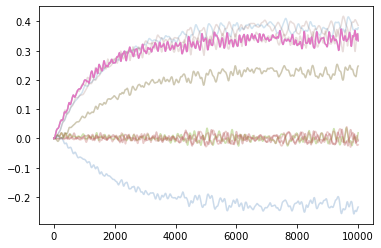

In [65]:
plt.plot(cov[0].reshape(-1,16), alpha=0.2);
plt.plot(cov[0,:,2,2]);

In [68]:
R_sample = results.var(axis=2)[:,0] 
S_sample = results.var(axis=2)[:,2]

In [69]:
L = (results[:,0] * results[:,3] - results[:,1] * results[:,2])
H_sample = L.mean(axis=1)/2

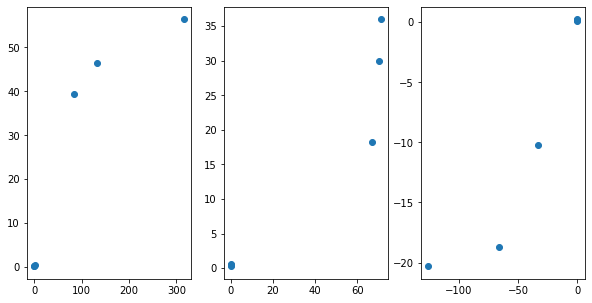

In [70]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(S, S_sample[..., -1])
plt.subplot(132)
plt.scatter(R, R_sample[..., -1])
plt.subplot(133)
plt.scatter(H, H_sample[..., -1])

In [75]:
T = results[:,1,:,:]
# T = L/2
hlines = R

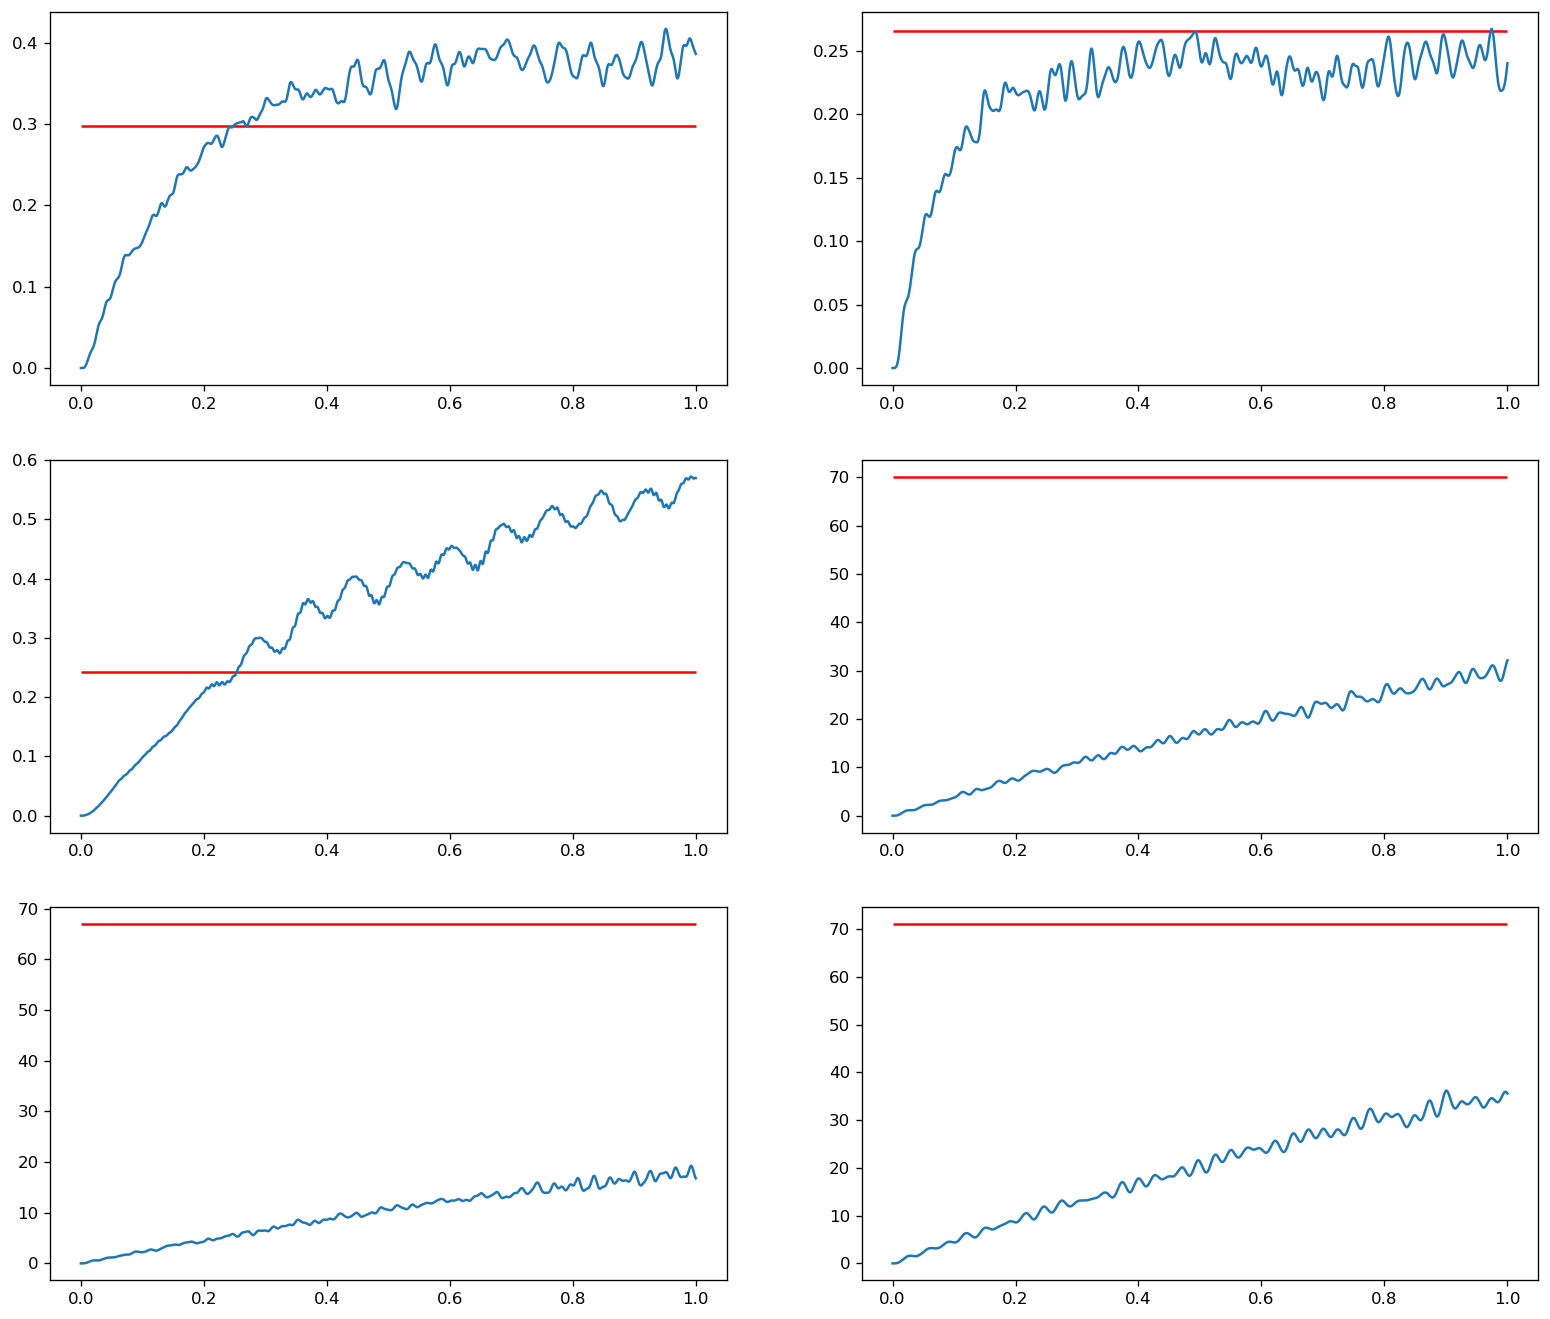

In [76]:
fig, axs = plt.subplots(T.shape[0]//2,2,figsize=(16,14),dpi=120)
for ax, xi,h in zip(axs.flatten(),T[:,:,:], hlines):
    ax.plot(time, xi.var(axis=0))
    ax.hlines(y=h, xmin=0, xmax=max(time), colors="r")